In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

/Users/alessandropranzo/.pyenv/versions/3.10.15/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:
BASE_MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModel.from_pretrained(BASE_MODEL_NAME).to(device)

In [3]:
trial = "trial"
inputs = tokenizer(trial, return_tensors="pt", truncation=True, padding=True).to(device)
with torch.no_grad():
    outputs = base_model(**inputs)

# Get the mean of the last hidden states as the embedding
embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
print("Embedding shape:", embedding.shape)

Embedding shape: torch.Size([768])


In [4]:
print(embedding.cpu().numpy())

[ 3.96046728e-01 -9.34696421e-02 -2.15155572e-01  5.82471490e-03
 -2.04394870e-02 -2.03971684e-01  3.17448318e-01 -3.40260744e-01
  8.70069861e-03 -5.62833957e-02  1.26066757e-02  3.91553752e-02
  1.06407568e-01  6.97647780e-02 -2.46400565e-01 -7.24412426e-02
 -4.94238846e-02 -1.74391016e-01  4.03612614e-01 -5.39168715e-02
  4.70209688e-01 -1.76969856e-01  7.00409785e-02  1.75824389e-01
 -1.12026557e-01  1.29165962e-01 -2.48683214e-01  1.83445662e-01
 -2.13266671e-01 -1.68625861e-01 -2.37480491e-01 -1.76618621e-01
 -9.61141735e-02  2.07960010e-01 -4.25660126e-02 -2.37067193e-01
  2.45116577e-01  1.52303334e-02 -2.54675597e-01 -1.90814257e-01
 -1.47683486e-01 -5.53335659e-02 -2.80570358e-01  4.62984256e-02
  1.20720237e-01 -8.94525647e-02 -5.62782407e-01  1.53813854e-01
 -2.60744300e-02  4.07916009e-01 -6.14837334e-02  2.60999560e-01
 -1.13839507e-02  1.42849728e-01  2.37615913e-01  1.28001243e-01
  5.42413816e-02 -4.77594547e-02  9.91405845e-02 -7.71518946e-02
  1.34574205e-01  2.68306

In [ ]:
trial_df = pd.read_csv("cleaned_train/ArgentinaBelgium72.csv")

In [6]:
trial_df.head()

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,11_0,11,0,0,1404575400000,@user: argentina vs belgium\n\nwho wins? |
1,11_0,11,0,0,1404575400000,@user time to focus on belgium winning the wor...
2,11_0,11,0,0,1404575400000,@user: global stadium: #joinin with our #world...
3,11_0,11,0,0,1404575400000,@user: #popefrancis. uh-oh. argentina vs belgi...
4,11_0,11,0,0,1404575400000,@user: if he scores vs #bel we'll award a mess...


In [7]:
trial_df.shape

(313803, 6)

In [8]:
trial_df[trial_df["EventType"]==1].shape

(190859, 6)

In [9]:
grouped_df = trial_df.groupby('ID').agg({'Timestamp': list,'Tweet': list,'EventType': list}).reset_index()

In [10]:
grouped_df["n_tweets"] = grouped_df["Tweet"].apply(lambda x: len(x))

In [11]:
grouped_df.shape

(130, 5)

In [12]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets
0,11_0,"[1404575400000, 1404575400000, 1404575400000, ...","[@user: argentina vs belgium\n\nwho wins? | , ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2330
1,11_1,"[1404575461000, 1404575461000, 1404575461000, ...","[@user come on belgium, @user: messi and aguer...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2021
2,11_10,"[1404576001000, 1404576001000, 1404576001000, ...",[@user: win a signed #messi jersey!\nif messi ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2239
3,11_100,"[1404581401000, 1404581401000, 1404581401000, ...",[all my friends are backing belgium #bel \ni'm...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2418
4,11_101,"[1404581461000, 1404581461000, 1404581461000, ...",[@user: vincent kompany back-tracking from mes...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2406


In [13]:
grouped_df = grouped_df.sort_values("ID", key=(lambda x: x.apply(lambda y: int(y.split('_')[1]))))
grouped_df.reset_index(drop=True, inplace=True)

In [14]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets
0,11_0,"[1404575400000, 1404575400000, 1404575400000, ...","[@user: argentina vs belgium\n\nwho wins? | , ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2330
1,11_1,"[1404575461000, 1404575461000, 1404575461000, ...","[@user come on belgium, @user: messi and aguer...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2021
2,11_2,"[1404575521000, 1404575521000, 1404575521000, ...",[@user @user it happens for the world cup too ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1775
3,11_3,"[1404575581000, 1404575581000, 1404575581000, ...",[#arg vs #bel omg i like both teams but today ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2291
4,11_4,"[1404575641000, 1404575641000, 1404575641000, ...",[argentina and belguim is gonna be such a gooo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2456


In [15]:
grouped_df["n_tweets"].mean()

np.float64(2413.869230769231)

In [16]:
grouped_df["Assertion"] = grouped_df["EventType"].apply(lambda x: False if (1 in x) and (0 in x) else True)
grouped_df["Timestamp Assertion"] = grouped_df["Timestamp"].apply(lambda x: False if (len(set(x)) == 1) else True)
print(grouped_df["Assertion"].unique())
print(grouped_df["Timestamp Assertion"].unique())

[ True]
[ True]


In [17]:
grouped_df["EventType"] = grouped_df["EventType"].apply(lambda x: x[0])
grouped_df.drop(columns=["Assertion"], inplace=True)
grouped_df.drop(columns=["Timestamp Assertion"], inplace=True)
grouped_df.head()


,ID,Timestamp,Tweet,EventType,n_tweets
0,11_0,"[1404575400000, 1404575400000, 1404575400000, ...","[@user: argentina vs belgium\n\nwho wins? | , ...",0,2330
1,11_1,"[1404575461000, 1404575461000, 1404575461000, ...","[@user come on belgium, @user: messi and aguer...",0,2021
2,11_2,"[1404575521000, 1404575521000, 1404575521000, ...",[@user @user it happens for the world cup too ...,0,1775
3,11_3,"[1404575581000, 1404575581000, 1404575581000, ...",[#arg vs #bel omg i like both teams but today ...,0,2291
4,11_4,"[1404575641000, 1404575641000, 1404575641000, ...",[argentina and belguim is gonna be such a gooo...,0,2456


In [ ]:
grouped_df["Timestamp"] = grouped_df["Timestamp"].apply(lambda x: [datetime.datetime.fromtimestamp(y/1000) for y in x])
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets
0,11_0,"[2014-07-05 17:50:00, 2014-07-05 17:50:00, 201...","[@user: argentina vs belgium\n\nwho wins? | , ...",0,2330
1,11_1,"[2014-07-05 17:51:01, 2014-07-05 17:51:01, 201...","[@user come on belgium, @user: messi and aguer...",0,2021
2,11_2,"[2014-07-05 17:52:01, 2014-07-05 17:52:01, 201...",[@user @user it happens for the world cup too ...,0,1775
3,11_3,"[2014-07-05 17:53:01, 2014-07-05 17:53:01, 201...",[#arg vs #bel omg i like both teams but today ...,0,2291
4,11_4,"[2014-07-05 17:54:01, 2014-07-05 17:54:01, 201...",[argentina and belguim is gonna be such a gooo...,0,2456


In [19]:
grouped_df[grouped_df["EventType"]==1].shape

(78, 5)

In [20]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = base_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def minute_embedding(texts):
    embeddings = [get_embedding(text) for text in texts]
    return torch.stack(embeddings).mean(dim=0).cpu().numpy()

In [ ]:
from tqdm import tqdm

tqdm.pandas()
grouped_df["Embedding"] = grouped_df["Tweet"].progress_apply(lambda x: minute_embedding(x))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 130/130 [59:37<00:00, 27.52s/it]


In [22]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets,Embedding
0,11_0,"[2014-07-05 17:50:00, 2014-07-05 17:50:00, 201...","[@user: argentina vs belgium\n\nwho wins? | , ...",0,2330,"[0.041983977, -0.08007118, 0.32538167, -0.0428..."
1,11_1,"[2014-07-05 17:51:01, 2014-07-05 17:51:01, 201...","[@user come on belgium, @user: messi and aguer...",0,2021,"[0.046064354, -0.07699028, 0.31636396, -0.0489..."
2,11_2,"[2014-07-05 17:52:01, 2014-07-05 17:52:01, 201...",[@user @user it happens for the world cup too ...,0,1775,"[0.059103355, -0.069916755, 0.30833194, -0.052..."
3,11_3,"[2014-07-05 17:53:01, 2014-07-05 17:53:01, 201...",[#arg vs #bel omg i like both teams but today ...,0,2291,"[0.047395326, -0.0755258, 0.3095702, -0.052382..."
4,11_4,"[2014-07-05 17:54:01, 2014-07-05 17:54:01, 201...",[argentina and belguim is gonna be such a gooo...,0,2456,"[0.05148725, -0.07734874, 0.31518087, -0.05672..."


In [ ]:
repr_2d_pca = PCA(n_components=2).fit_transform(np.stack(grouped_df["Embedding"].values))
repr_3d_pca = PCA(n_components=3).fit_transform(np.stack(grouped_df["Embedding"].values))
y = grouped_df["EventType"].values

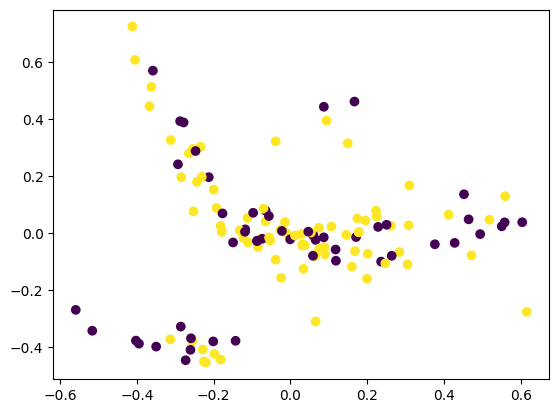

In [ ]:
plt.scatter(repr_2d_pca[:, 0], repr_2d_pca[:, 1], c=y, cmap="viridis")

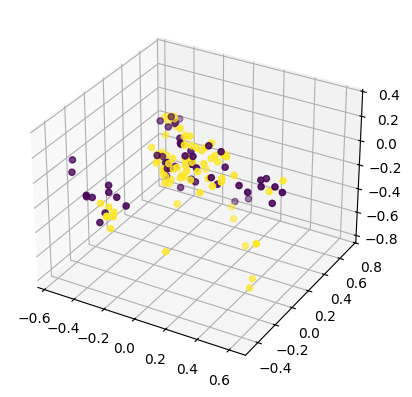

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_pca[:, 0], repr_3d_pca[:, 1], repr_3d_pca[:, 2], c=y, cmap="viridis")

In [27]:
from sklearn.manifold import TSNE

repr_2d_tsne = TSNE(n_components=2).fit_transform(np.stack(grouped_df["Embedding"].values))
repr_3d_tsne = TSNE(n_components=3).fit_transform(np.stack(grouped_df["Embedding"].values))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


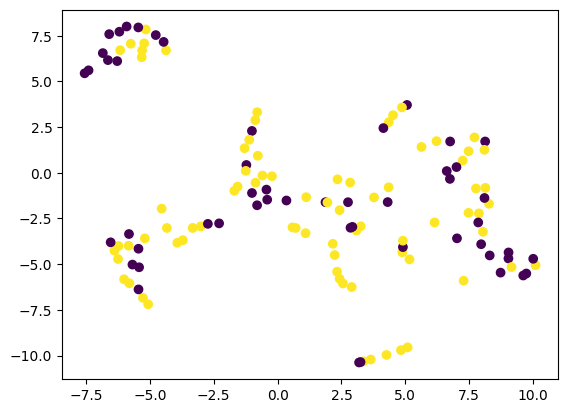

In [28]:
plt.scatter(repr_2d_tsne[:, 0], repr_2d_tsne[:, 1], c=y, cmap="viridis")

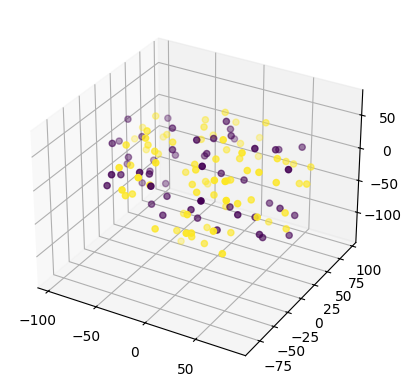

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_tsne[:, 0], repr_3d_tsne[:, 1], repr_3d_tsne[:, 2], c=y, cmap="viridis")

In [32]:
from collections import Counter

match_activity = Counter([])

for minute_timesteps in grouped_df["Timestamp"]:
    match_activity += Counter(minute_timesteps)


In [37]:
len(match_activity)

7801

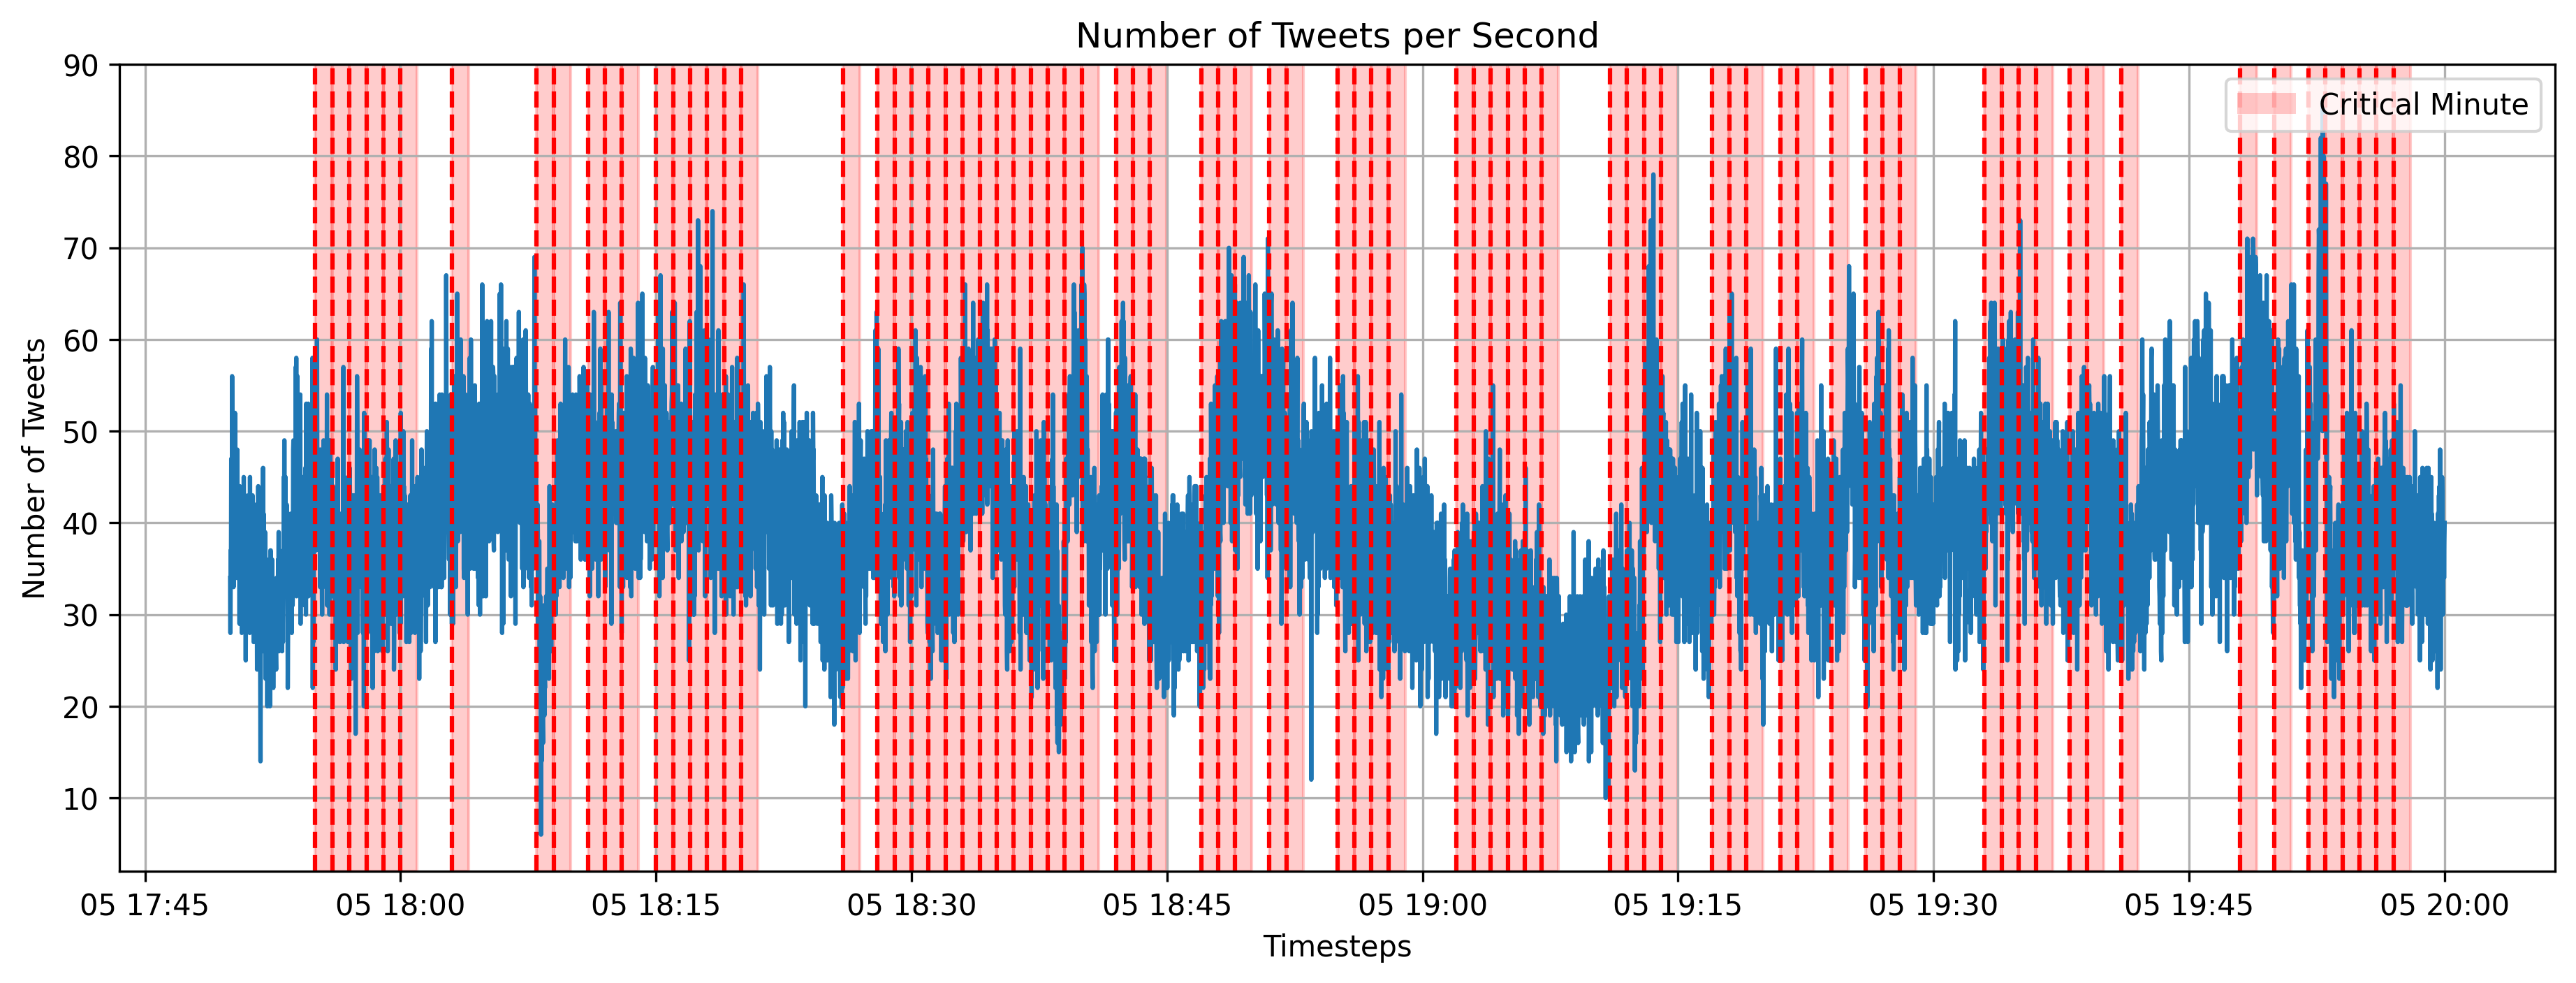

In [48]:
from matplotlib.patches import Patch
plt.figure(figsize=(15, 5), dpi=300)
plt.plot(list(match_activity.keys()), list(match_activity.values()))

for minute, outcome in enumerate(y):
    if outcome == 1:
        start_second = list(match_activity.keys())[minute*60]
        end_second = list(match_activity.keys())[min((minute+1)*60-1, len(match_activity)-1)]
        plt.axvline(x=start_second, color="red", linestyle="--")
        plt.axvspan(start_second, end_second, color="red", alpha=0.2)

plt.xlabel('Timesteps')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Second')
legend_elements = [
    Patch(facecolor='red', alpha=0.2, label='Critical Minute')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

REMARK: we might take a weighted average of the number of tweets per second over the minute we are considering (there might be an higher number of tweets per second in the seconds when something important happens).